Stretch Parameters: 
midtones balance: 	0.0009285051067780873
shadows clipping: 	0.0
highlights clipping: 	1



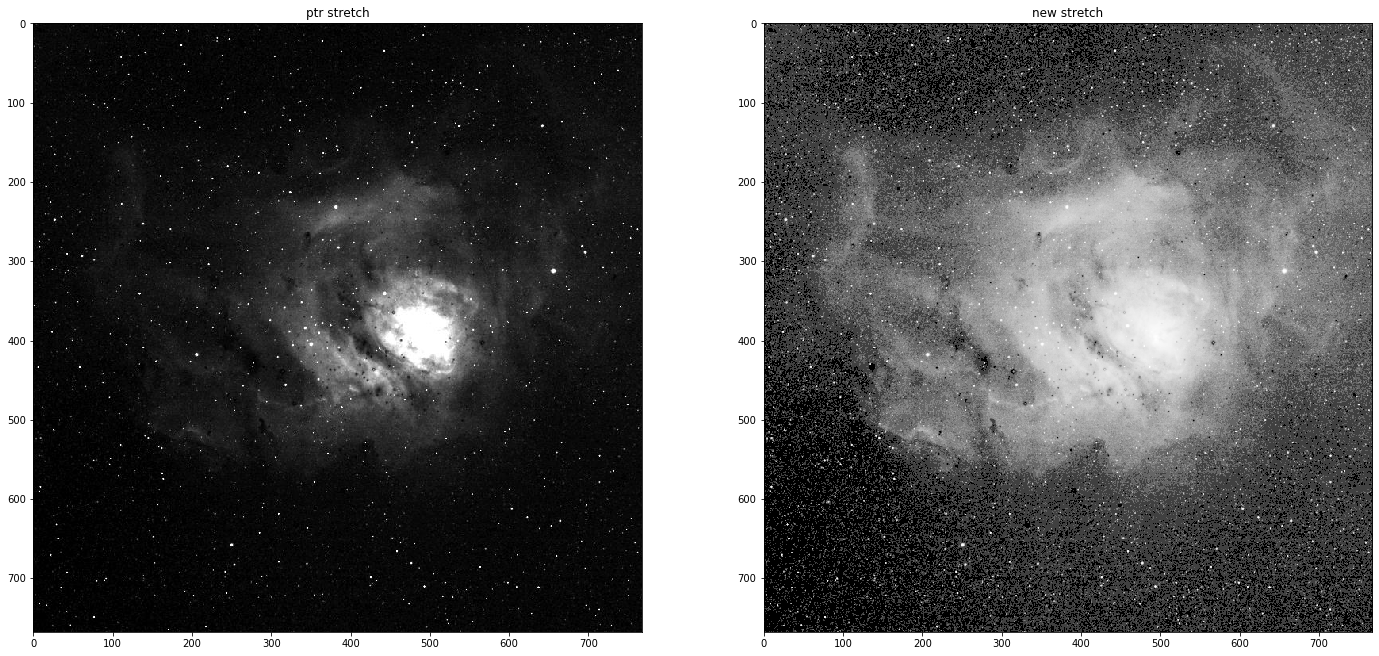

In [5]:
import time
import sys
import json
import requests
import urllib

import astropy
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
from PIL import Image
import scipy

# Plotting params
matplotlib.rcParams['figure.figsize'] = [24,24]

def getAvgDev(data):
    """Return the average deviation from the median.
    
    Args:
        data (np.array): array of floats, presumably the image data
    """
    median = np.median(data)
    n = data.size
    median_deviation = lambda x: abs(x - median)
    avg_dev = np.sum( median_deviation(data) / n )
    return avg_dev

def mtf(m, x):
    """Midtones Transfer Function
    
    MTF(m, x) = {
        0                for x == 0,
        1/2              for x == m,
        1                for x == 1,
        
        (m - 1)x         
        --------------   otherwise.
        (2m - 1)x - m
    }
    
    See the section "Midtones Balance" from 
    https://pixinsight.com/doc/tools/HistogramTransformation/HistogramTransformation.html
    
    Args: 
        m (float): midtones balance parameter
                   a value below 0.5 darkens the midtones
                   a value above 0.5 lightens the midtones
        x (np.array): the data that we want to copy and transform.
    """
    shape = x.shape
    x = x.flatten()
    zeros = x==0
    halfs = x==m
    ones = x==1
    others = np.logical_xor((x==x), (zeros + halfs + ones))
    
    x[zeros] = 0
    x[halfs] = 0.5
    x[ones] = 1
    x[others] = (m - 1) * x[others] / ((((2 * m) - 1) * x[others]) - m)
    return x.reshape(shape)

def stretch(data, m, c0, c1):
    """ Stretch the image.
    
    Args:
        data (np.array): the original image data array.
        m (float): midtones balance
        c0: shadows clipping point
        c1: highlights clipping point
        
    Returns:
        np.array: the stretched image data 
    """
    
    # Deep copy so the input data array doesn't change.
    d = np.empty_like(data)
    d[:] = data
    
    # Selectors for pixels that lie below or above the shadows clipping point
    below = d < c0
    above = d >= c0
    
    # Clip everything below the shadows clipping point
    d[below] = 0
    
    # For the rest of the pixels: apply the midtones transfer function
    d[above] = mtf(m, (d[above] - c0)/(1 - c0))
    return d

def autoSTF(data, shadows_clip, target_bkg):
    """ Get the stretch parameters automatically.
    m is the midtones balance
    c0 is the shadows clipping point
    c1 is the highlights clipping point
    """
    median = np.median(data)
    avgDev = getAvgDev(data)
    
    c0 = np.clip(median + shadows_clip*avgDev, 0, 1)
    m = mtf(target_bkg, median-c0)
    
    return {
        "c0": c0,
        "c1": 1,
        "m": m
    }

def get_image_urls(base_filename):
    """
    Get urls for jpg and fits files taken at photon ranch. 
    
    The base filename is the filename starting with the sitecode and ending before
    the EX00 number. 
    
    Example: 'saf-sq01-20200628-00000408' 
    
    """
    
    # Photon ranch api to get the image urls
    url = "https://api.photonranch.org/api/download"

    # Fits
    body = json.dumps({
        "object_name": f"{base_filename}-EX10.fits.bz2"
    })
    fits_url = requests.post(url, body).text
    if requests.get(fits_url).status_code != 200:
        body = json.dumps({
            "object_name": f"{base_filename}-EX13.fits.bz2"
        })
        fits_url = requests.post(url, body).text
        if requests.get(fits_url).status_code != 200:
            body = json.dumps({
                "object_name": f"{base_filename}-EX01.fits.bz2"
            })
            fits_url = requests.post(url, body).text
        
        
    
    # Jpg
    body = json.dumps({
        "object_name": f"{base_filename}-EX10.jpg"
    })
    jpg_url = requests.post(url, body).text
    if requests.get(jpg_url).status_code != 200:
        body = json.dumps({
            "object_name": f"{base_filename}-EX13.jpg"
        })
        jpg_url = requests.post(url, body).text
    
    # Check if url is valid:
    status_code = requests.get(fits_url).status_code
    
    return {
        "ok": status_code == 200,
        "jpg": jpg_url,
        "fits": fits_url,
    }


def plot_stretch_results(base_filename, shadows_clip=-1.25, target_bkg=0.25, save_image=False):
    """
    Apply the stretch to the given image and plot them side by side
    """
    
    urls = get_image_urls(base_filename)
    
    if not urls["ok"]: 
        print("Error downloading file. Check that the base_filename is valid.")
        return
    
    data = fits.open(urls["fits"])[0].data

    data = data / np.max(data)

    # Create plotting grid
    f, axarr = plt.subplots(1,2)

    # Plot the unstretched image
    #axarr[0].imshow(data, cmap='gray')

    params = autoSTF(data, shadows_clip, target_bkg)

    m = params["m"]
    c0 = params["c0"]
    c1 = params["c1"]
    print("Stretch Parameters: ")
    print(f"midtones balance: \t{m}")
    print(f"shadows clipping: \t{c0}")
    print(f"highlights clipping: \t{c1}")
    print('')

    # Stretch the image and plot it
    stretched_image = stretch(data, m, c0, c1)
    axarr[1].imshow(stretched_image, cmap='gray')
    axarr[1].title.set_text('new stretch')

    # Display the PTR jpg stretch for comparison
    img_bytes = urllib.request.urlopen(urls["jpg"]).read()
    img = Image.open(BytesIO(img_bytes))
    axarr[0].imshow(img, cmap='gray')
    axarr[0].title.set_text('ptr stretch')
    
    if save_image:
        f.savefig(f'stretch-{base_filename}.png', bbox_inches='tight', dpi=100)
        
        
def stretch_from_file(filename, shadows_clip=-1.25, target_bkg=0.25, save_image=False):
    
    # Filename must be a path to the file. 
    # If it's in the same directory, filename should be like './filename.fits'
    data = fits.getdata(filename)
    data = data / np.max(data)

    params = autoSTF(data, shadows_clip, target_bkg)

    m = params["m"]
    c0 = params["c0"]
    c1 = params["c1"]
    print("Stretch Parameters: ")
    print(f"midtones balance: \t{m}")
    print(f"shadows clipping: \t{c0}")
    print(f"highlights clipping: \t{c1}")
    print('')

    # Stretch the image and plot it
    stretched_image = stretch(data, m, c0, c1)
    plt.imshow(stretched_image, cmap='gray')
    plt.colorbar()
    
    if save_image:
        plt.savefig(f'stretch-{filename[2:]}.png', bbox_inches='tight', dpi=100)

    

base_filename = 'saf-sq01-20200628-00000408'  # M8
#base_filename = 'saf-sq01-20200916-00001926'  # Dust donuts
#base_filename = 'wmd-sq01-20200830-00000289'  # Flat Screen
#base_filename = 'saf-sq01-20200914-00001923'  # Some stars
#base_filename = 'saf-test-20200626-00000007'  # Some stars


target_bkg = 0.25
shadows_clip = -3.25

plot_stretch_results(
    base_filename, 
    target_bkg=target_bkg, 
    shadows_clip=shadows_clip, 
    save_image=True)



target_bkg = 0.25
shadows_clip = -3.25

#filename = './saf-kb01-20200524-00001265-EX13.fits'
#filename = './wmd-gf03-20191022-00000605-EX13.fits'
#filename = './g.fits'
#filename = './ha.fit'
#filename = './bb.fit'
#filename = './orion_sulpher.fits'
#filename = './saf-ngc1566.fits'
#filename = './m16.fits'
#stretch_from_file(filename, target_bkg=target_bkg, shadows_clip=shadows_clip, save_image=False)


    
    